In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
from collections import defaultdict

main_path = ls.main_path
sys.path.append(main_path)

/home/alex/NuMI/PELEE/


In [2]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() # the default option is FHC, RHC needs different arguments

In [3]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [4]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)



In [5]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265


angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [6]:
tree = "NeutrinoSelectionFilter"


#new
#BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune
#This is with the new GENIE tune
#NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune

DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND

mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]
ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]
#nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]


uproot_v = [mc,ext,data,dirt] 


variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        #"trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
        #"trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
        #"trk_start_x_v","trk_start_z_v","trk_start_z_v",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
    ]

varMC = ["nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x"]

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]


['mc_pdg', 'interaction', 'pion_e', 'topological_score', 'CosmicIP', 'reco_nu_vtx_sce_y', 'true_e_visible', 'sub', 'pi0_e', 'theta', 'run', 'ccnc', 'slpdg', 'slnhits', 'evt', 'flash_pe', 'muon_e', 'reco_e', 'CosmicDirAll3D', 'nu_pdg', 'reco_nu_vtx_sce_x', '_opfilter_pe_veto', 'npi0', 'reco_nu_vtx_z', 'npion', 'slclustfrac', 'nslice', 'reco_nu_vtx_x', '_opfilter_pe_beam', 'reco_nu_vtx_y', 'nproton', 'slnunhits', 'backtracked_pdg', 'evnunhits', 'isVtxInFiducial', 'category', 'trk_llr_pid_score_v', 'CosmicIPAll3D', 'pi0truth_elec_etot', 'reco_nu_vtx_sce_z']


In [7]:
import pandas as pandas    
#dirt = dirt.pandas.df(variables + varMC + WEIGHTS + SYSTEMATICS, flatten=False)
#mc   =   mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)
#data = data.pandas.df(variables, flatten=False)
#ext  =  ext.pandas.df(variables, flatten=False)

dirt_var = variables + varMC + WEIGHTS + SYSTEMATICS
mc_var   = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC
data_var = variables
ext_var  = variables
#nue_var  = variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC


# This needs modifications (add variables from above)
uproot_v = [mc,ext,data,dirt] 
var_v    = [mc_var,ext_var,data_var,dirt_var] 

#nue  = nue.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        mc = CVDF
    elif ii == 1:
        ext = CVDF
    elif ii == 2:
        data = CVDF
    else:
        dirt =  CVDF

trk_llr_pid_v  [[0.82782626 -0.8194372 0.3865043 0.09241907] [0.66136134 0.26579022 -0.4465902] [0.9429299] ... [-0.7478028 -0.31272712 -0.07394644 0.6294419 -0.15682676 0.044288084] [0.9825717 0.8653566 0.30652303 0.37347093 0.0450483] [0.8391653 0.832069 0.35647532 0.38325506]]
trk_score_v  [[0.013178393 0.9346445 0.9606818 0.16331574] [0.9108349 0.45338693 0.94899696] [0.0006027788] ... [0.9460351 0.1035448 0.72438586 0.5656786 0.97891515 0.51936793] [1.0 0.0056803394 0.08460715 0.59094507 0.8683876] [0.034102786 0.08651647 0.49835193 0.06482802]]
Here:
trk_range_muon_mom_v  [[0.17937614 0.16509071 0.12815218 0.0944555] [0.14844838 0.096581735 0.12556528] [0.4635543] ... [0.17865215 0.19258761 0.102005966 0.14741157 0.085067436 0.04624264] [0.72576284 0.19006218 0.12427797 0.11919753 0.08485623] [0.1829412 0.16517013 0.13296928 0.10878313]]
trk_mcs_muon_mom_v  [[0.11600006 0.19500022 0.33199927 0.34799907] [0.3679988 0.21500026 1.1059957] [0.36599857] ... [0.2330003 0.122000076 0.16

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


trk_llr_pid_v  [[0.4775138] [0.9612796] [0.46180135 0.54934144 0.10673018] ... [0.73604786 0.15185338] [0.513903 0.09590046 0.101642326] [0.547429 0.42826256]]
trk_score_v  [[0.29486892] [0.00014609084] [1.0961453e-07 0.2947586 0.73173183] ... [0.13884807 0.712718] [0.3139902 0.7329207 0.863878] [0.85589015 0.32862234]]
Here:
trk_range_muon_mom_v  [[0.10813367] [0.55609524] [0.15396534 0.11052788 0.09672263] ... [0.15389663 0.06221006] [0.10815287 0.07369371 0.07062612] [0.1019842 0.09543209]]
trk_mcs_muon_mom_v  [[0.1380001] [0.42799848] [0.11400005 0.07899998 0.21100025] ... [0.17700018 14.999432] [0.085999995 14.998431 14.999432] [0.6589951 0.34699908]]
trk_llr_pid_v  [[0.61479425] [0.6336193 0.39911884 0.021630378] [0.7970757 -0.21337485 -0.3697966] ... [0.4188579] [0.6745422] [0.8221383 0.5234873 0.25720716 0.038982317]]
trk_score_v  [[0.35534355] [0.34817457 0.14082558 0.3428277] [0.0009466654 0.9058201 0.9391397] ... [0.27186927] [0.42120844] [0.82834244 0.8871221 0.7718351 0.00

# Weights

In [8]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [9]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    '''
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    '''


In [10]:
df_v = [mc,dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']


In [11]:
df_v = [mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
    
    # Cray cray weight fix
    #for ievt in range(df.shape[0]):
    #    reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
    #                         (df['weightsGenie'].iloc[ievt] == np.inf))
    #    df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [12]:
df_v = [mc,dirt,data,ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

# Adding variables

In [13]:
df_v = [mc,dirt,data,ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

data["bnbdata"] = np.ones_like(data["isVtxInFiducial"])
ext["extdata"] = np.ones_like(ext["isVtxInFiducial"])

In [14]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

/tmp/ipykernel_5006/3373323908.py:8: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


# Event Categories

In [15]:
data["is_signal"] = data["category"] == 11
mc["is_signal"]   = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"]  = ext["category"] == 11
#nue["is_signal"]  = nue["category"] == 11

In [16]:
mc   = mc.query('nu_e > 0.')
dirt = dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [mc,dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

# Selection

# Plotting part

In [17]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/home/alex/NuMI/PELEE/plotter.py'>

In [18]:
import plotter
import importlib
importlib.reload(plotter)

#nue = mc.query("(abs(nu_pdg) == 12 and ccnc == 0)") 
#nueMC = mc.query("(abs(nu_pdg) == 14 & ccnc == 0)")
##CHANGE
nue   = mc.query("(abs(nu_pdg) == 12 & ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55)")



samples = {
    "mc"  : mc,
    "nue" : nue,
    "data": data,
    "dirt": dirt,
    "ext" : ext
}

scaling   = 1
pot       =  2e+20             
mcratio   = pot/2.33652e+21
nueratio  = pot/2.37838e+22    
dirtratio = pot/1.42143e+21
extratio  = 5268051.0/9199232.74

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98
scalingDRT = 0.60 #0.35

weights = { "mc"  : mcratio  * SPLIT * scaling,
            "nue"  : mcratio  * SPLIT * scaling, #needed as the plotter needs nue but we're not using
            #"nue" : nueratio  * SPLIT * scaling,
            "ext" : extratio * SPLIT * scalingEXT,    
            "dirt": dirtratio* SPLIT * scalingDRT,   
}

my_plotter = plotter.Plotter(samples, weights, pot=pot)
print(weights)

{'mc': 0.08559738414394057, 'nue': 0.08559738414394057, 'ext': 0.5612087579382191, 'dirt': 0.08442202570650682}


In [20]:
SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"

nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8  and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5  and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8  and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
order w sum  23.489826961576558  c  31
order w sum  33.350448876927  c  3
order w sum  41.83870850741041  c  5
order w sum  137.5040287897792  c  21
order w sum  242.8593024224917  c  2
order w sum  9.652278435880657  c  1
order w sum  0  c  12
order w sum  0.09127470793649041  c  10
order w sum  5.0426719422558905  c  11
total  544.8985376166357

SUMS
[23.489826961576558, 56.84027583850359, 98.67898434591392, 236.18301313569322, 479.04231555818455, 488.69459399406514, 488.69459399406514, 488.78586870200166, 493.82854064425754]
[33.35044887692703, 41.83870850741033, 137.

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


nue
data
dirt
ext
Universes 500
mc
nue
data
dirt
ext
Universes 500
mc
nue
data
dirt
ext
Add Drawing Geo Sys
Number of variations Universes 10
draw Sys
n_data  [ 44 213 140  55  21  12   2   1   4   0]


/home/alex/NuMI/PELEE/plotter.py:458: RuntimeWarning: divide by zero encountered in true_divide
  ERR_STAT = 3. / ( 1./data + 2./mc )
/home/alex/NuMI/PELEE/plotter.py:266: RuntimeWarning: divide by zero encountered in true_divide
  return (data-mc)**2 / data


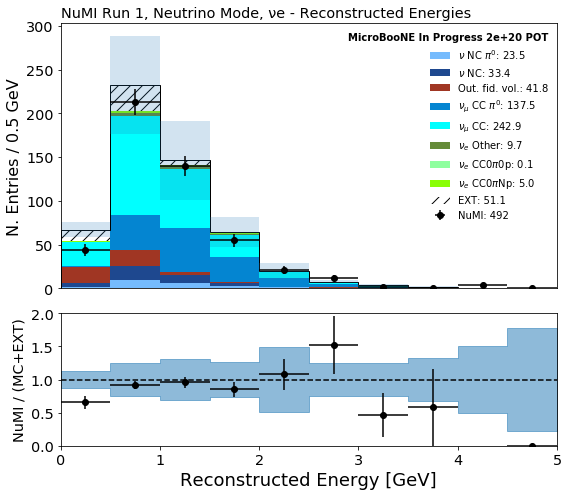

In [33]:
#Now check on a variable
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

import matplotlib.pyplot as plt
import matplotlib

#can this be done with nue_e too? For efficiencies?
VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= SEL_QUERY ,
    #kind="interaction",
    kind="event_category",
    draw_sys  = True, 
    draw_geoSys = True, 
    draw_data = True,
    genieweight = "weightSplineTimesTuneTimesPPFX",  
    stacksort=3,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, Neutrino Mode, νe - Reconstructed Energies',loc='left')
#ax1.set_yscale("log")
fig.tight_layout()

## Purity and Efficiency

Selection Efficiency = no. reconstructed neutrinos classified as numu CC that pass selection / total number of these simulated in the fiducial volume.

Selection Purity = no. reconstructed neutrinos classified as numu CC that pass selection / total number of selected neutrinos in any classification.

### Smearing Matrix Work

In [39]:
# plot the smearing matrix 
def plot_smearing(selected, signal, true, reco, bins, norm=False): 
    fig = plt.figure(figsize=(10, 6))
    
    smear = plt.hist2d(selected.query(signal)[true],selected.query(signal)[reco],
                   bins, cmin=0.000000001, cmap='OrRd')
    
    zero_copy_smear = np.copy(smear[0].T)
    
    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if np.isnan(zero_copy_smear[i,j]):
                zero_copy_smear[i,j]= 0

    for i in range(len(bins)-1): # reco bins i (y axis) rows
        for j in range(len(bins)-1): # true bins j (x axis) cols
            if smear[0].T[i,j] > 0: 
                if smear[0].T[i,j]>80: 
                    col='white'
                else: 
                    col='black'
                    
                binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                        
                plt.text(binx_centers, biny_centers, round(smear[0].T[i,j], 1), 
                    color=col, ha="center", va="center", fontsize=12)

    cbar = plt.colorbar()
    cbar.set_label('Selected Signal Events', fontsize=15)

    if norm: 
        plt.close()
        
        norm_array = smear[0].T
    
        # for each truth bin (column): 
        for j in range(len(bins)-1): 
        
            reco_events_in_column = [ norm_array[i][j] for i in range(len(bins)-1) ]
            tot_reco_events = np.nansum(reco_events_in_column)
        
            # replace with normalized value 
            for i in range(len(bins)-1): 
                norm_array[i][j] =  norm_array[i][j] / tot_reco_events
    
        # now plot
        fig = plt.figure(figsize=(10, 6))
        plt.pcolor(bins, bins, norm_array, cmap='OrRd', vmax=1)
        
        zero_copy_smear_norm = np.copy(norm_array)

        for i in range(len(bins)-1): # reco bins i (y axis) rows
            for j in range(len(bins)-1): # true bins j (x axis) cols
                if np.isnan(zero_copy_smear_norm[i,j]):
                    zero_copy_smear_norm[i,j]= 0

        print(zero_copy_smear_norm)
    
        # Loop over data dimensions and create text annotations.
        for i in range(len(bins)-1): # reco bins (rows)
            for j in range(len(bins)-1): # truth bins (cols)
                if norm_array[i][j]>0: 
                
                    if norm_array[i][j]>0.7: 
                        col = 'white'
                    else: 
                        col = 'black'
                    
                    binx_centers = smear[1][j]+(smear[1][j+1]-smear[1][j])/2
                    biny_centers = smear[2][i]+(smear[2][i+1]-smear[2][i])/2
                
                    plt.text(binx_centers, biny_centers, round(norm_array[i][j], 2), 
                         ha="center", va="center", color=col, fontsize=12)
      
        cbar = plt.colorbar()
        cbar.set_label('Fraction of Reco Events in True Bin', fontsize=15)
        
        #np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
        #   zero_copy_smear_norm,
        #   delimiter =", ", 
        #   fmt ='% s')

    plt.xlabel('True ν Energy [GeV]', fontsize=15)
    plt.ylabel('Reco ν Energy [GeV]', fontsize=15)
    plt.text(0.1, 4.8, r'MicroBooNE In Progress', fontweight='bold')
    
    plt.show()

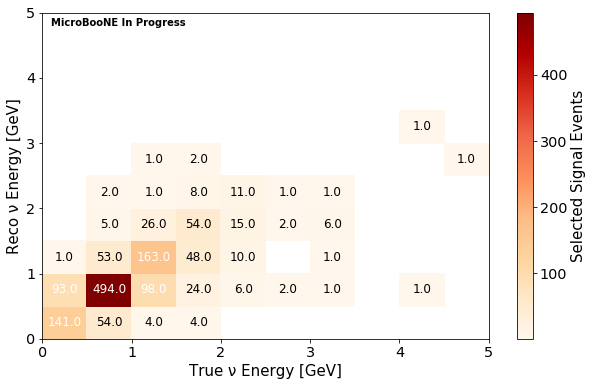

In [40]:
# true nu energy 
true_var = 'nu_e'

# reconstructed nu energy 
reco_var = 'reco_e'

bins = np.arange(0, 5.5, 0.5)

#fiduc_q = "true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and ((nu_pdg) == 12 and ccnc == 0) and nproton > 0"

fiduc_q  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
fiduc_q  += " and category == 2"


selected = mc.query(SEL_QUERY)
selected_fid = selected.query(fiduc_q)

# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins)

[[0.6   0.089 0.014 0.029 0.    0.    0.    0.    0.    0.   ]
 [0.396 0.812 0.334 0.171 0.143 0.4   0.111 0.    0.5   0.   ]
 [0.004 0.087 0.556 0.343 0.238 0.    0.111 0.    0.    0.   ]
 [0.    0.008 0.089 0.386 0.357 0.4   0.667 0.    0.    0.   ]
 [0.    0.003 0.003 0.057 0.262 0.2   0.111 0.    0.    0.   ]
 [0.    0.    0.003 0.014 0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.5   0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


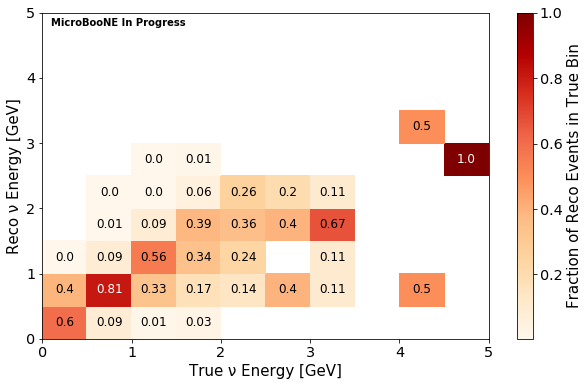

In [41]:
# relationship between true & reco values
plot_smearing(selected_fid, fiduc_q, true_var, reco_var, bins, norm=True)

In [42]:
with open('batch_eff_numu_fig_full_500_catsel_nopions_recoE_matrix.csv') as file:
    content = file.readlines()
effs = content[0:]
    
for i in range(10):
    effs[i]=effs[i].rstrip().rstrip(',')
    effs[i] = float(effs[i])
    
print(effs)
print("")
#----------------------------------------------------------------------------------

with open('numu_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv') as file:
    content = file.readlines()
smear = content[0:]

for i in range(10):
    smear[i]=smear[i].rstrip().rstrip(',')
    smear[i] = [float(idx) for idx in smear[i].split(', ')]
    
print((smear))
print("")

#------------------------------------------------------------------

#print(np.dot(effs, data_signal))
for i in range(10):
    smear[i] = [a*b for a,b in zip(smear[i], effs)]
    
print(smear)
print("")

np.savetxt("numu_full_500_catsel_nopions_recoE_usingSelection_smearcept.csv", 
   smear,
   delimiter =", ", 
   fmt ='% s')

#--------------------------------------------------------

#Now test by multiplying with the prior_true_signal

with open('numu_full_500_catsel_nopions_recoE_usingSelection_prior_true_signal.csv') as file:
    content = file.readlines()
prior_true = content[0:]
    
for i in range(10):
    prior_true[i]=prior_true[i].rstrip().rstrip(',')
    prior_true[i] = float(prior_true[i])
    
print(prior_true)
print("")

made_data_sig = np.dot(smear, prior_true)
print(made_data_sig)
print("")

for i in made_data_sig:
    print(i)

[0.4750760510587767, 0.3366111763807367, 0.14775031337657218, 0.05974603037171938, 0.03389391775518658, 0.01910834236787515, 0.008119696272598143, 0.0071000384159739995, 0.010589988569390038, 0.0]

[[0.6, 0.08881578947368421, 0.013651877133105802, 0.02857142857142857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.39574468085106385, 0.8125, 0.33447098976109213, 0.17142857142857143, 0.14285714285714285, 0.4, 0.1111111111111111, 0.0, 0.5, 0.0], [0.00425531914893617, 0.08717105263157894, 0.5563139931740614, 0.34285714285714286, 0.23809523809523808, 0.0, 0.1111111111111111, 0.0, 0.0, 0.0], [0.0, 0.008223684210526315, 0.08873720136518772, 0.38571428571428573, 0.35714285714285715, 0.4, 0.6666666666666666, 0.0, 0.0, 0.0], [0.0, 0.003289473684210526, 0.0034129692832764505, 0.05714285714285714, 0.2619047619047619, 0.2, 0.1111111111111111, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0034129692832764505, 0.014285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0], [0.0, 0.0, 0.0, 

In [43]:
##------------------------------------------------------------------